In [1]:
import requests, re, pandas as pd, numpy as np
from itertools import product
from bs4 import BeautifulSoup as bs
from scipy import stats
import pandas as pd
import numpy as np
from datetime import datetime
from xgboost import XGBClassifier, XGBRegressor
import utils

In [2]:
import os
import pickle
from datetime import datetime
def ensure_folder_exists(folder_path):
    """
    Creates the specified folder if it does not already exist
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


def load_pickle(file_path):
    """
    Loads a pickle from the file system
    """
    return pickle.load(open(file_path, 'rb')) if os.path.isfile(file_path) else None


def save_pickle(file_path, data):
    """
    Saves the specified object as a pickle to the file system
    """
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
        
target = 'Y:/Internship/SoMin/Notebook/raw/20220523/adlibrary_ads.pkl'
if os.path.getsize(target) > 0: 
    all_ads = load_pickle(target)
    print(len(all_ads))
else:
    print('empty')

38985


In [3]:
def get_image_url(source):
    """
    function to extract image_url from the retreived data from Ad Library API
    Why?: the URL obtained via the endpoint is not an image_url but instead a url for a snapshot of the entire ad
    """
    
    source = soup(requests.get(ad_url).content, 'html.parser')
    pattern = r'"resized_image_url":"(?:\\.|[^"\\])*"' # find resized_image_url : <image_url>
    try:
        image_url = re.findall(pattern, str(source))[0].split('"resized_image_url":')[1].replace('\\', '').replace('"', '').replace("'", '')
    except:
        image_url = np.nan
    return image_url


def process_ads(ads):
    """
    processes Ads retrieved from Ads Archive (FB Ad Library)
    """
    df = pd.DataFrame(ads)    
    clean = []
    for _, row in df.iterrows():
        m = {}
        m['search_term'] = row['topic']
        m['country'] = row['country']
        m['page_id'] = row['page_id']
        m['page_name'] = row['page_name']
        m['ad_id'] = row['id']
        
        m['ad_creation_date'] = row['ad_creation_time']
        if m['ad_creation_date'] is np.nan:
            continue
        m['ad_creation_month'] = int(m['ad_creation_date'][5:7])
        
        
        m['delivery_start'] = row['ad_delivery_start_time']
        if m['delivery_start'] is np.nan:
            continue
            
        m['delivery_stop'] = row['ad_delivery_stop_time']
        if m['delivery_stop'] is np.nan:
            continue
        
        start = datetime.strptime(m['delivery_start'], '%Y-%m-%d')
        stop = datetime.strptime(m['delivery_stop'], '%Y-%m-%d')
        m['delivery_period'] = (stop-start).days
        
        m['ad_url'] = row['ad_snapshot_url']
        
#         try:
#             source = soup(requests.get(row['ad_snapshot_url']).content, 'html.parser')
#             m['image_url'] = get_image_url(source)
#         except:
#             m['image_url'] = np.nan # some ads are wrongly classified as having images
        
        ad_body = row['ad_creative_bodies']
        m['ad_body'] = ad_body[0] if (type(ad_body) == list) else ''
        m['uses_multi_body'] = 1 if ((type(ad_body) == list) and (len(set(ad_body)) > 1)) else 0
        
        link_capt = row['ad_creative_link_captions']
        m['link_caption'] = link_capt[0] if (type(link_capt) == list) else ''
        m['uses_multi_capt'] = 1 if ((type(link_capt) == list) and (len(set(link_capt)) > 1)) else 0
        
        link_title = row['ad_creative_link_titles']
        m['link_title'] = link_title[0] if (type(link_title) == list) else ''
        m['uses_multi_title'] = 1 if ((type(link_title) == list) and (len(set(link_title)) > 1)) else 0
        
        link_desc = row['ad_creative_link_descriptions']
        m['link_description'] = link_desc[0] if (type(link_desc) == list) else ''
        m['uses_multi_desc'] = 1 if ((type(link_desc) == list) and (len(set(link_desc)) > 1)) else 0
        
        lang = row['languages']
        m['language'] = ','.join(lang) if (type(lang) == list) else ''
        m['uses_multi_lang'] = 1 if ((type(lang) == list) and (len(set(lang)) > 1)) else 0
        
        m['funded_by'] = row['bylines'] if type(row['bylines']) == str else ''
        m['currency'] = row['currency']
        
        spend = row['spend']
        m['min_spend'] = spend.get('lower_bound', np.nan)
        m['max_spend'] = spend.get('upper_bound', np.nan)
        
        impressions = row['impressions']
        m['min_impressions'] = impressions.get('lower_bound', np.nan)
        m['max_impressions'] = impressions.get('upper_bound', np.nan)
        
        audience_size = row['estimated_audience_size']
        m['min_audience_size'] = audience_size.get('lower_bound', np.nan) if type(audience_size)==dict else np.nan
        m['max_audience_size'] = audience_size.get('upper_bound', np.nan) if type(audience_size)==dict else np.nan
        
        
        if m['max_impressions'] is np.nan or m['min_impressions'] is np.nan: 
            m['impressions'] = 0
            continue
        else:
            m['impressions'] = (int(m['max_impressions']) + int(m['min_impressions']))/2
            
        if m['max_spend'] is np.nan or m['min_spend'] is np.nan: 
            m['spend'] = 0
            continue
        else:
            m['spend'] = (int(m['max_spend']) + int(m['min_spend']))/2
        
        
        if m['max_impressions'] is np.nan or m['max_impressions'] == 0:
            m['CPM'] = 0
            continue
        else:
            m['CPM'] = int(m['max_spend']) / int(m['max_impressions']) * 1000
        
        
        if m['max_impressions'] is np.nan or m['max_impressions'] == 0:
            m['CPM2'] = 0
            continue
        else:
            m['CPM2'] = int(m['spend']) / int(m['impressions']) * 1000
        
        
        
        platforms = row['publisher_platforms']
        m['facebook'] = 1 if ((type(platforms) == list) and ('facebook' in platforms)) else 0
        m['instagram'] = 1 if ((type(platforms) == list) and ('instagram' in platforms)) else 0
        m['messenger'] = 1 if ((type(platforms) == list) and ('messenger' in platforms)) else 0
        m['audience_network'] = 1 if ((type(platforms) == list) and ('audience_network' in platforms)) else 0
        
        m['demographic_dist'] = row['demographic_distribution']
        clean.append(m)
        
    return pd.DataFrame(clean)

In [4]:
# start = datetime.strptime('2022-03-12', '%Y-%m-%d')
# stop = datetime.strptime('2022-04-16', '%Y-%m-%d')
# type((stop-start).days)

In [5]:
df = process_ads(all_ads)
df

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(df['ad_id'].unique()).count()

In [ ]:
df.info()

In [ ]:
df.max_spend.describe()

In [ ]:
df.iloc[120]

In [ ]:
df.iloc[5].ad_url

In [ ]:
df.columns

In [ ]:
err_index = []
err_ad_id = []
for index in range(df.shape[0]):
    img_url = utils.get_image_url(df.iloc[index].ad_url)
    try:
        utils.download_image(img_url, f'Y:/Internship/SoMin/Notebook/raw/Image/{str(df.iloc[index].ad_id)}.png')
        print(f'download index {index}, ad_id = {df.iloc[index].ad_id}')
    except Exception as e:
        print('Some error happened:', e)
        err_index.append(index)
        err_ad_id.append(df.iloc[index].ad_id)

In [47]:
save_pickle(f'Y:/Internship/SoMin/Notebook/log/error_ad_id.pkl', err_ad_id)

In [27]:
j = 0
img_url = utils.get_image_url(df.iloc[6].ad_url)
img_url

'https://scontent.fsgn5-9.fna.fbcdn.net/v/t39.35426-6/258267279_938689570405214_8432556817527078711_n.jpg?stp=dst-jpg_s600x600&_nc_cat=105&ccb=1-7&_nc_sid=cf96c8&_nc_ohc=yGumIlYdC1oAX94EUlK&_nc_ht=scontent.fsgn5-9.fna&oh=00_AT-dih4ae-6Iauq3aXmEEIg350cViuVUsqSKSaDkoeFsIw&oe=6293641E'

In [26]:
# utils.download_image(img_url, 'Y:/Internship/SoMin/Notebook/raw/img.png')

In [1]:
# from facebookads.adobjects.adaccount import AdAccount

# account = AdAccount('act_3016969751720365')
# # params = {
# #     'hashes': [
# #         <IMAGE_1_HASH>,
# #         <IMAGE_2_HASH>,
# #     ],
# # }
# images = account.get_ad_images()

In [33]:
df['min_spend']=df['min_spend'].astype('int64')
df['max_spend']=df['max_spend'].astype('int64')
# df['max_impressions'].fillna(0, inplace=True)
df['min_impressions']=df['min_impressions'].astype('int64')
df['max_impressions']=df['max_impressions'].astype('int64')

df['country']=df['country'].astype('category')
df['search_term']=df['search_term'].astype('category')

# # df['min_audience_size']=df['min_audience_size'].astype('int64')
# # df['max_audience_size']=df['max_audience_size'].astype('int64')

In [34]:
sum(df['max_impressions'].isna())

0

In [35]:
# N = len(all_ads)
# for i in range(N):
#     print(df.iloc[i]['max_spend'], df.iloc[i]['max_impressions'], df.iloc[i]['CPM'], df.iloc[i]['CPM2'])

In [36]:
print('number of posts that use multiple body type', sum(df['uses_multi_body']))
print('number of posts that use multiple captions', sum(df['uses_multi_capt']))
print('number of posts that use multiple titles', sum(df['uses_multi_title']))
print('number of posts that use multiple description', sum(df['uses_multi_desc']))
print('number of posts that use multiple language', sum(df['uses_multi_lang']))

print('over ', len(all_ads))

number of posts that use multiple body type 1671
number of posts that use multiple captions 194
number of posts that use multiple titles 1893
number of posts that use multiple description 1006
number of posts that use multiple language 69
over  38985


In [37]:
df = df[df['max_spend']>0]
df = df[df['CPM']>0]
df = df[df['CPM2']>0]
df = df[df['max_impressions']>0]
df.shape

(38874, 38)

In [30]:
df['CPM'] = pd.DataFrame(np.log(df['CPM']))
df['CPM2'] = pd.DataFrame(np.log(df['CPM2']))
df['max_spend'] = pd.DataFrame(np.log(df['max_spend']))
df['max_impressions'] = pd.DataFrame(np.log(df['max_impressions']))

In [31]:
df = df[(np.abs(stats.zscore(df['CPM'])) < 2)]
df = df[(np.abs(stats.zscore(df['CPM2'])) < 2)]
df = df[(np.abs(stats.zscore(df['max_spend'])) < 2)]
df = df[(np.abs(stats.zscore(df['max_impressions'])) < 2)]
df.shape

(31991, 38)

In [32]:
df['CPM'] = pd.cut(x=df['CPM'], bins=[2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], labels=[0,1,2,3,4,5], ordered=True)
df['CPM2'] = pd.cut(x=df['CPM2'], bins=[2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], labels=[0,1,2,3,4,5], ordered=True)

df['CPM'] = df['CPM'].astype('str')
df['CPM2'] = df['CPM2'].astype('str')

df = df[df['CPM'] != 'nan']
df = df[df['CPM2'] != 'nan']

In [33]:
df

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,max_audience_size,impressions,spend,CPM,CPM2,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,3,...,100000,2499.5,49.5,2,1,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."
1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,2022-05-06,3,...,500000,499.5,49.5,5,5,1,0,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g..."
2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,2022-05-08,5,...,5000,1499.5,49.5,3,2,1,1,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g..."
3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,2022-04-22,15,...,50000,1499.5,49.5,3,2,1,0,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g..."
6,ad-tech,US,246491525549550,Ed Post,623648402121445,2021-11-18,11,2021-11-18,2021-11-25,7,...,NaN,2499.5,49.5,2,1,1,1,0,0,"[{'percentage': '0.000634', 'age': '35-44', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38863,analytics,GB,197246230417092,Superweek - European Analytics Summit,366810920860085,2019-06-07,6,2019-06-09,2019-06-10,1,...,NaN,2499.5,49.5,2,1,1,0,0,0,"[{'percentage': '0.280292', 'age': '25-34', 'g..."
38867,analytics,BR,1445990532337716,ShareAmerica,491096738951834,2021-01-26,1,2021-01-27,2021-01-31,4,...,NaN,4499.5,49.5,1,0,1,0,0,0,"[{'percentage': '0.243153', 'age': '45-54', 'g..."
38869,analytics,BR,115255603631922,Ricardo Caminhoneiro 22310,600549173955885,2020-08-27,8,2020-08-27,2020-08-29,2,...,NaN,2499.5,49.5,2,1,1,1,1,0,"[{'percentage': '0.046118', 'age': '35-44', 'g..."
38871,analytics,BR,197246230417092,Superweek - European Analytics Summit,1409280549253390,2019-06-07,6,2019-06-09,2019-06-11,2,...,NaN,499.5,49.5,5,5,1,0,0,0,"[{'percentage': '0.395973', 'age': '25-34', 'g..."


In [34]:
df['CPM2'].describe()

count     31981
unique        6
top           5
freq      20356
Name: CPM2, dtype: object

C:\Users\root\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CPM', ylabel='count'>

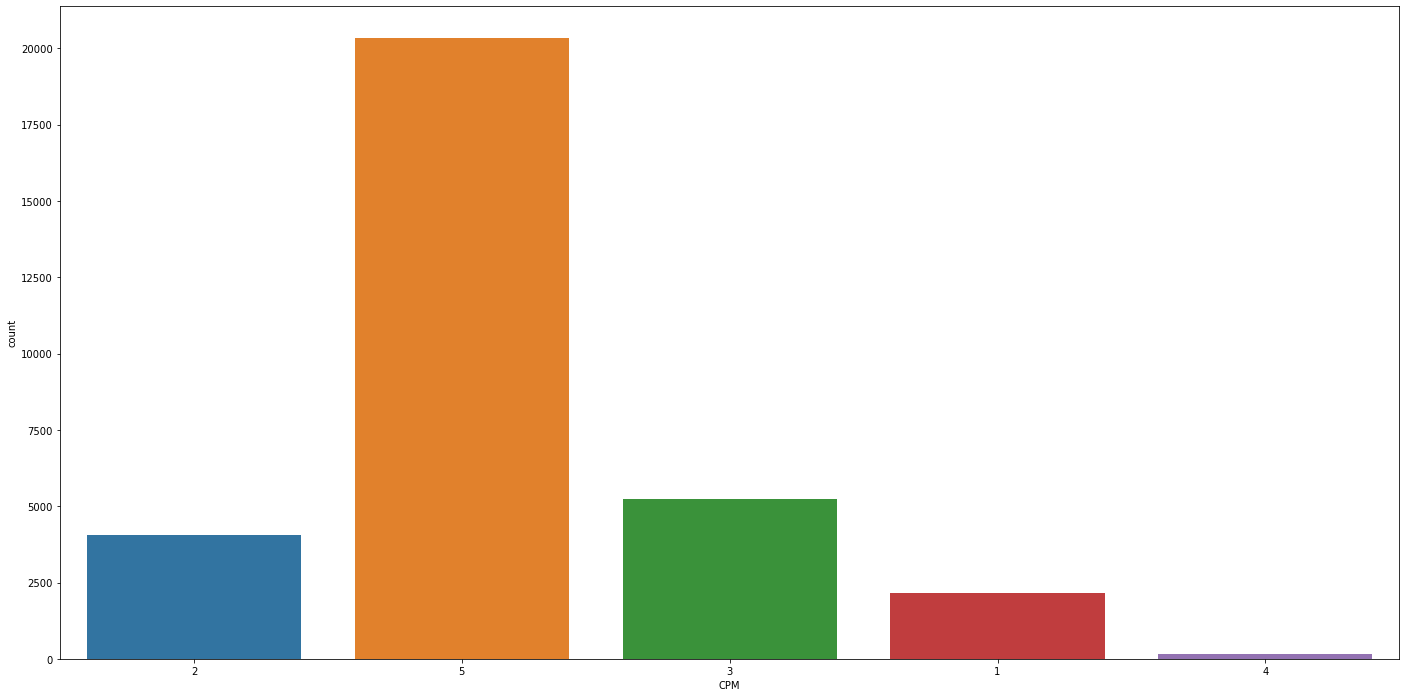

In [35]:
import matplotlib.pyplot as plt
import seaborn as sb
f, axes = plt.subplots(1, 1, figsize=(24, 12))
# sb.boxplot(data = df['CPM'].value_counts(), orient = "h", ax = axes[0])
# sb.histplot(data = df['CPM'].value_counts(), ax = axes[1])
# sb.violinplot(data = df['CPM'].value_counts(), orient = "h", ax = axes[2])
sb.countplot(df['CPM'])

C:\Users\root\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CPM2', ylabel='count'>

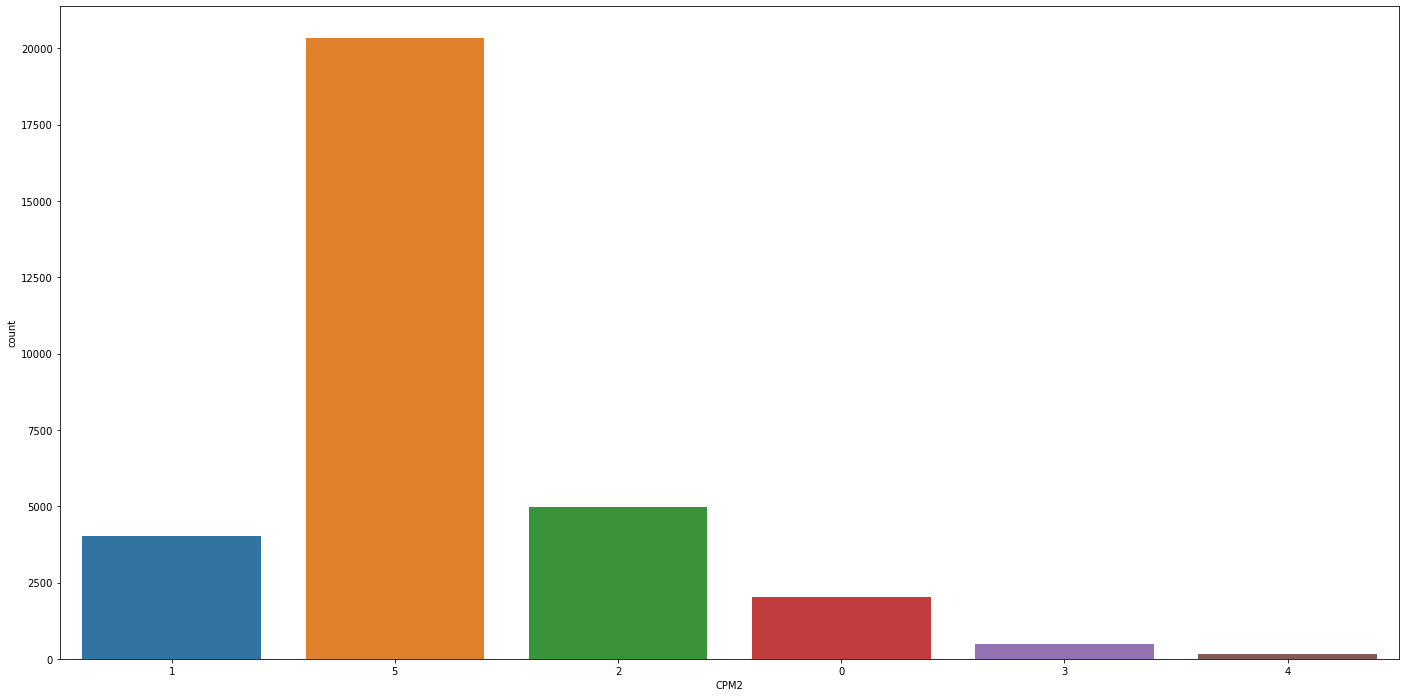

In [36]:
import matplotlib.pyplot as plt
import seaborn as sb
f, axes = plt.subplots(1, 1, figsize=(24, 12))
# sb.boxplot(data = df['CPM'].value_counts(), orient = "h", ax = axes[0])
# sb.histplot(data = df['CPM'].value_counts(), ax = axes[1])
# sb.violinplot(data = df['CPM'].value_counts(), orient = "h", ax = axes[2])
sb.countplot(df['CPM2'])

In [ ]:
# f, axes = plt.subplots(1, 3, figsize=(24, 12))
# sb.boxplot(data = df['CPM2'], orient = "h", ax = axes[0])
# sb.histplot(data = df['CPM2'], ax = axes[1])
# sb.violinplot(data = df['CPM2'], orient = "h", ax = axes[2])

In [ ]:
# f, axes = plt.subplots(1, 3, figsize=(24, 12))
# sb.boxplot(data = df['max_spend'], orient = "h", ax = axes[0])
# sb.histplot(data = df['max_spend'], ax = axes[1])
# sb.violinplot(data = df['max_spend'], orient = "h", ax = axes[2])

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(24, 12))
sb.boxplot(data = df['max_impressions'], orient = "h", ax = axes[0])
sb.histplot(data = df['max_impressions'], ax = axes[1])
sb.violinplot(data = df['max_impressions'], orient = "h", ax = axes[2])

In [37]:
type(df['CPM2'].iloc[0])

str

# Modelling


In [38]:
sum(df['delivery_period'].isna())

0

SHAPE
(25592, 2)
(6399, 2)
(25592, 1)
(6399, 1)


ValueError: could not convert string to float: '(4.5, 5.0]'

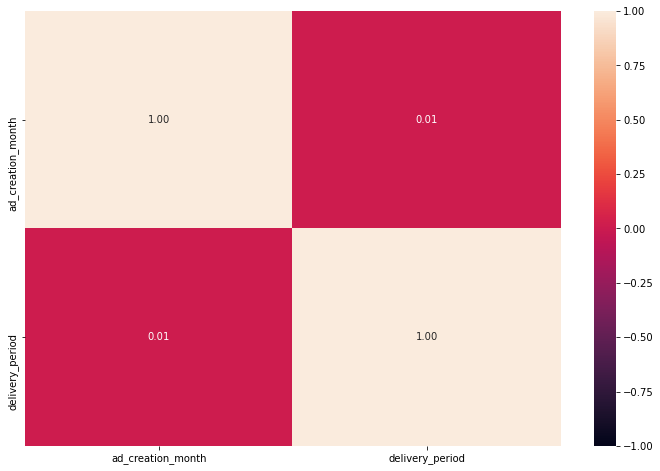

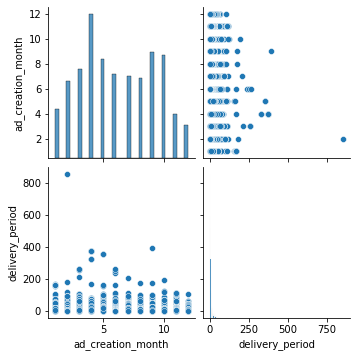

In [25]:
import matplotlib.pyplot as plt
import seaborn as sb

predictor=['ad_creation_month', 'delivery_period']
target=['CPM2']

X = df[predictor]
y = df[target]

DF = pd.concat([y, X], axis = 1).reindex(y.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

sb.pairplot(data = DF)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error

print()
print("REPORT")
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_test, y_test_pred))

In [ ]:
df.columns

In [ ]:
df.dtypes

### XGB

In [40]:
predictor=['ad_creation_month', 'delivery_period']

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
target=['CPM2']

X = df[predictor]
y = df[target]

y = y.astype('int64')

# y = LabelBinarizer().fit_transform(y)

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, accuracy_score

print()
print("REPORT")
print("Train accuracy", accuracy_score(y_train, y_train_pred))
print("Test accuracy", accuracy_score(y_test, y_test_pred))

SHAPE
(25584, 2)
(6397, 2)
(25584, 1)
(6397, 1)
[10:20:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

REPORT
Train accuracy 0.6513836772983115
Test accuracy 0.6412380803501642


C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [41]:
y.value_counts()

CPM2
5       20356
2        4962
1        4013
0        2009
3         483
4         158
dtype: int64

In [42]:
y_train.value_counts()

CPM2
5       16296
2        3986
1        3185
0        1599
3         387
4         131
dtype: int64

In [47]:
from catboost import CatBoostClassifier

predictor=['search_term', 'country', 'ad_creation_month', 'delivery_period']
target=['CPM2']

X = df[predictor]
y = df[target]

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

cat_features = ['search_term', 'country']

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=True
)



y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, roc_auc_score

print()
print("REPORT")
print('Accuracy score:')
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
# print()
# print('Roc auc score:')
# print(roc_auc_score(y_train, clf.predict_proba(X_train), multi_class="ovr"))
# print(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr"))
print()
print(classification_report(y_test, y_test_pred))

SHAPE
(25584, 4)
(6397, 4)
(25584, 1)
(6397, 1)
0:	learn: 1.6178202	test: 1.6211563	best: 1.6211563 (0)	total: 50.4ms	remaining: 202ms
1:	learn: 1.5032753	test: 1.5084670	best: 1.5084670 (1)	total: 98.2ms	remaining: 147ms
2:	learn: 1.4212003	test: 1.4281742	best: 1.4281742 (2)	total: 178ms	remaining: 119ms
3:	learn: 1.3584998	test: 1.3670501	best: 1.3670501 (3)	total: 250ms	remaining: 62.4ms
4:	learn: 1.3087033	test: 1.3184110	best: 1.3184110 (4)	total: 362ms	remaining: 0us

bestTest = 1.318411043
bestIteration = 4


REPORT
Accuracy score:
0.6381722951844903
0.6309207440987963

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       428
           1       0.00      0.00      0.00       802
           2       0.00      0.00      0.00      1004
           3       0.00      0.00      0.00        92
           4       0.00      0.00      0.00        35
           5       0.63      1.00      0.77      4036

    accuracy                       

C:\Users\root\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from catboost import CatBoostClassifier

predictor=['search_term', 'country', 'ad_creation_month', 'delivery_period']
target=['CPM']

X = df[predictor]
y = df[target]

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

cat_features = ['search_term', 'country']

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=True
)



y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

from sklearn.metrics import mean_squared_error, accuracy_score

print()
print("REPORT")
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

In [48]:
df2 = df

In [51]:
df2.columns

Index(['search_term', 'country', 'page_id', 'page_name', 'ad_id',
       'ad_creation_date', 'ad_creation_month', 'delivery_start',
       'delivery_stop', 'delivery_period', 'ad_url', 'ad_body',
       'uses_multi_body', 'link_caption', 'uses_multi_capt', 'link_title',
       'uses_multi_title', 'link_description', 'uses_multi_desc', 'language',
       'uses_multi_lang', 'funded_by', 'currency', 'min_spend', 'max_spend',
       'min_impressions', 'max_impressions', 'min_audience_size',
       'max_audience_size', 'impressions', 'spend', 'CPM', 'CPM2', 'facebook',
       'instagram', 'messenger', 'audience_network', 'demographic_dist'],
      dtype='object')

In [52]:
df.iloc[0]

search_term                                                    ad-tech
country                                                             US
page_id                                                100470349235347
page_name                                                   Save Texas
ad_id                                                  762749274711708
ad_creation_date                                            2022-05-03
ad_creation_month                                                    5
delivery_start                                              2022-05-03
delivery_stop                                               2022-05-06
delivery_period                                                      3
ad_url               https://www.facebook.com/ads/archive/render_ad...
ad_body              In a technical report updated for the first ti...
uses_multi_body                                                      0
link_caption                                     oceanservice.noaa.gov
uses_m

In [68]:
df2 = df[df['uses_multi_body'] == 1]
df2.shape

(1072, 38)

In [71]:
pd.set_option('display.max_colwidth', None)
# dummy = pd.DataFrame(df2[df2['page_id'] == '131942223874']['ad_body'])
dummy = pd.DataFrame(df2['ad_body'])
dummy.head(1000)

,ad_body
43,"Patriotic Apparel is HERE! 🇺🇸\n\nWhen you wear one of our shirts, you’re letting people know that you’re not afraid to love your country; you’re not ashamed of being an American, you're proud to be an American.\n\nWe provide American quality without the B.S."
45,"Patriotic Apparel is HERE! 🇺🇸\n\nWhen you wear one of our shirts, you’re letting people know that you’re not afraid to love your country; you’re not ashamed of being an American, you're proud to be an American.\n\nWe provide American quality without the B.S."
78,"Patriotic Apparel is HERE! 🇺🇸\n\nWhen you wear one of our shirts, you’re letting people know that you’re not afraid to love your country; you’re not ashamed of being an American, you're proud to be an American.\n\n""Once you put this shirt on, you'll travel back in time to the days of our Founding Fathers. George Washington will shake your hand and by you a beer at the local tavern. (Not really) Shirt is made of quality material and feels great against my DadBod. I ordered a size up and it's a little big but overall I am very happy with my purchase.""\n\nWe provide American quality without the B.S."
79,"Patriotic Apparel is HERE! 🇺🇸\n\nWhen you wear one of our shirts, you’re letting people know that you’re not afraid to love your country; you’re not ashamed of being an American, you're proud to be an American.\n\n""Once you put this shirt on, you'll travel back in time to the days of our Founding Fathers. George Washington will shake your hand and by you a beer at the local tavern. (Not really) Shirt is made of quality material and feels great against my DadBod. I ordered a size up and it's a little big but overall I am very happy with my purchase.""\n\nWe provide American quality without the B.S."
395,"Americans need to get the government off their backs, so they can live life as they want and THRIVE. \n\nThe path to THRIVING includes school choice, VocTech training at both the high school level and for unemployed and underemployed adults, all of which Bobby Scott has consistently voted against."
...,...
38163,Moody's Analytics proyecta que una victoria de Joe Biden marcaría el comienzo de un mayor crecimiento económico y de empleo que con el presidente Trump.
38174,Moody's Analytics dice que el plan económico de Joe Biden crearía 7 millones de empleos más que el de Donald Trump.
38175,Moody's Analytics proyecta que una victoria de Joe Biden marcaría el comienzo de un mayor crecimiento económico y de empleo que bajo el presidente Trump.
38176,Moody's Analytics dice que el plan económico de Joe Biden crearía 7 millones de empleos más que el de Donald Trump.


In [1]:
df['ad_url']

NameError: name 'df' is not defined